In [1]:
using Pkg
# Pkg.activate(".")
# Pkg.instantiate()
using Revise
using EasyHybrid
using Lux
using Optimisers
using WGLMakie
using Random
using LuxCore
using CSV, DataFrames
using EasyHybrid.MLUtils
using Statistics
using Plots
using JLD2


In [2]:
# 03 - flexiable BD, both oBD and mBD will be learnt by NN
testid = "03_hybridNN";
version = "v20251209"
results_dir = joinpath(@__DIR__, "eval");
target_names = [:BD, :SOCconc, :CF, :SOCdensity];

# input
df = CSV.read(joinpath(@__DIR__, "data/lucas_preprocessed_v20251125.csv"), DataFrame; normalizenames=true)
println(size(df))

# scales
scalers = Dict(
    :SOCconc   => 0.151, # g/kg, log(x+1)*0.151
    :CF        => 0.263, # percent, log(x+1)*0.263
    :BD        => 0.529, # g/cm3, x*0.529
    :SOCdensity => 0.167, # kg/m3, log(x)*0.167
);

# mechanistic model
function SOCD_model(; SOCconc, CF, oBD, mBD)
    ϵ = 1e-7

    # invert transforms
    soct = (exp.(SOCconc ./ scalers[:SOCconc]) .- 1) ./ 1000
    soct = clamp.(soct, ϵ, Inf)
    
    cft = (exp.(CF ./ scalers[:CF]) .- 1) ./ 100
    cft = clamp.(cft, 0, 0.99)

    # compute BD safely
    som = 1.724f0 .* soct
    
    denom = som .* mBD .+ (1f0 .- som) .* oBD
    denom = clamp.(denom, ϵ, Inf)

    BD = (oBD .* mBD) ./ denom
    BD = clamp.(BD, ϵ, Inf)

    # SOCdensity
    SOCdensity = soct .* 1000 .* BD .* (1 .- cft)
    SOCdensity = clamp.(SOCdensity, 1, Inf)

    # scale
    SOCdensity = log.(SOCdensity) .* scalers[:SOCdensity]
    BD = BD .* scalers[:BD]

    return (; BD, SOCconc, CF, SOCdensity, oBD, mBD)
end


# param bounds
parameters = (
    SOCconc = (0.01f0, 0.0f0, 1.0f0),   # fraction
    CF      = (0.15f0, 0.0f0, 1.0f0),   # fraction,
    oBD     = (0.20f0, 0.05f0, 0.40f0),  # also NN learnt, g/cm3
    mBD     = (1.20f0, 0.75f0, 2.0f0),  # NN leanrt
)

# define param for hybrid model
neural_param_names = [:SOCconc, :CF, :mBD, :oBD]
# global_param_names = [:oBD]
forcing = Symbol[]
targets = [:BD, :SOCconc, :SOCdensity, :CF]       # SOCconc is both a param and a target

# predictor
predictors = Symbol.(names(df))[18:end-6]; # CHECK EVERY TIME 
nf = length(predictors)


(56117, 385)


362

In [3]:
# hyperparameters
# search space
hidden_configs = [ 
    (512, 256, 128, 64, 32, 16),
    (512, 256, 128, 64, 32), 
    (256, 128, 64, 32, 16),
    (256, 128, 64, 32),
    (256, 128, 64),
    (128, 64, 32, 16),
    (128, 64, 32),
    (64, 32, 16)
];
batch_sizes = [128, 256, 512];
lrs = [1e-3, 5e-4, 1e-4];
activations = [relu, swish, gelu];

configs = [(h=h, bs=bs, lr=lr, act=act)
           for h in hidden_configs
           for bs in batch_sizes
           for lr in lrs
           for act in activations]

println(length(configs))


216


In [4]:
# cross-validation
k = 5;
folds = make_folds(df, k = k, shuffle = true);
rlt_list_param = Vector{DataFrame}(undef, k)
rlt_list_pred = Vector{DataFrame}(undef, k)  

@info "Threads available: $(Threads.nthreads())"

[ Info: Threads available: 96


In [5]:

@time for test_fold in 1:k
    @info "Training outer fold $test_fold of $k"

    train_folds = setdiff(1:k, test_fold)
    train_idx = findall(in(train_folds), folds)
    train_df = df[train_idx, :]
    test_idx  = findall(==(test_fold), folds)
    test_df = df[test_idx, :]

    # track best config for this outer fold
    lk = ReentrantLock()
    best_val_loss = Inf
    best_config = nothing
    best_result = nothing
    best_model_path = nothing
    best_model = nothing

    Threads.@threads for i in 1:length(configs)
        try
            cfg = configs[i]
        
            h  = cfg.h
            bs = cfg.bs
            lr = cfg.lr
            act = cfg.act
            println("Testing h=$h, bs=$bs, lr=$lr, activation=$act")
    
            hm_local = constructHybridModel(
                predictors,
                forcing,
                targets,
                SOCD_model,
                parameters,
                neural_param_names,
                [];
                hidden_layers = collect(h),
                activation = act,
                scale_nn_outputs = true,
                input_batchnorm = false,
                start_from_default = true
            )
    
            rlt = train(
                hm_local, train_df, ();
                nepochs = 200,
                batchsize = bs,
                opt = AdamW(lr),
                training_loss = :mse,
                loss_types = [:mse, :r2],
                shuffleobs = true,
                file_name = "$(testid)_config$(i)_fold$(test_fold).jld2",
                random_seed = 42,
                patience = 15,
                yscale = identity,
                monitor_names = [:oBD, :mBD],
                agg = mean,
                return_model = :best,
                show_progress = false,
                plotting = false,
                hybrid_name = "$(testid)_config$(i)_fold$(test_fold)" 
            )
    
            lock(lk)
            if rlt.best_loss < best_val_loss
                best_val_loss = rlt.best_loss
                best_config = cfg
                best_result = rlt
                best_model_path = "best_model_$(testid)_config$(i)_fold$(test_fold).jld2"
                best_model = deepcopy(hm_local)
            end
            unlock(lk)
        catch err
            @error "Thread $i crashed" exception = err
            @error sprint(showerror, err)
        end

    end

    # register best hyper paramets
    agg_name = Symbol("mean")
    r2s  = map(vh -> getproperty(vh, agg_name), best_result.val_history.r2)
    mses = map(vh -> getproperty(vh, agg_name), best_result.val_history.mse)
    best_epoch = max(best_result.best_epoch, 1)

    local_results_param = DataFrame(
        h = string(best_config.h),
        bs = best_config.bs,
        lr = best_config.lr,
        act = string(best_config.act),
        r2 = r2s[best_epoch],
        mse = mses[best_epoch],
        best_epoch = best_epoch,
        test_fold = test_fold,
        path = best_model_path,
    )
    rlt_list_param[test_fold] = local_results_param

    # move best models and then remove tmp files
    cp(joinpath("output_tmp", best_model_path), joinpath("model", best_model_path * ".jld2"); force=true) 
    for f in readdir("output_tmp"; join=true)
        rm(f; force=true, recursive=true)
    end

    ps, st = best_result.ps, best_result.st
    (x_test,  y_test)  = prepare_data(best_model, test_df)
    ŷ_test, st_test = best_model(x_test, ps, LuxCore.testmode(st))
    # println(propertynames(ŷ_test))
    # println(propertynames(ŷ_test.parameters))

    for var in [:BD, :SOCconc, :CF, :SOCdensity, :oBD, :mBD]
        if hasproperty(ŷ_test, var)
            val = getproperty(ŷ_test, var)

            if val isa AbstractVector && length(val) == nrow(test_df)
                test_df[!, Symbol("pred_", var)] = val # per row

            elseif (val isa Number) || (val isa AbstractVector && length(val) == 1)
                test_df[!, Symbol("pred_", var)] = fill(Float32(val isa AbstractVector ? first(val) : val), nrow(test_df))
            end


        end
    end
    
    rlt_list_pred[test_fold] = test_df

end

rlt_param = vcat(rlt_list_param...)
rlt_pred = vcat(rlt_list_pred...)

# CSV.write(joinpath(results_dir, "$(testid)_cv.pred_$version.csv"), rlt_pred)
# CSV.write(joinpath(results_dir, "$(testid)_hyperparams_$version.csv"), rlt_param)


[ Info: Training outer fold 1 of 5


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 39 with best validation loss wrt mse: 0.015204759932015414
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 24 of 200 epochs with best validation loss wrt mse: 0.015204759932015414
[ Info: Training outer fold 2 of 5


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.015783998803665898
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.015783998803665898
[ Info: Training outer fold 3 of 5
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.01685891516326478
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.01685891516326478
[ Info: Training outer fold 4 of 5
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.016507673147958472
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.016507673147958472
[ Info: Training outer fold 5 of 5


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 45 with best validation loss wrt mse: 0.01606426419371068
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 30 of 200 epochs with best validation loss wrt mse: 0.01606426419371068


1295.219941 seconds (2.52 G allocations: 280.487 GiB, 4.67% gc time, 55.16% compilation time: <1% of which was recompilation)


Row,time,lat,lon,id,clay,bulk_density_tot,coarse_mass,ref,nuts0,ph_h2o,bd,total_n,sand,silt,cf,ocd,soc,cropland_extent_glad_interpolate_p_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20240604,ndvi_glad_landast_ard2_seasconv_m_yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,evi_glad_landsat_ard2_seasconv_m_30m_s_YYYY0901_YYYY1031_eu_epsg_3035_v20231127,pft_grass_nat_esa_cci_lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg_4326_v20230616,pft_trees_bd_esa_cci_lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg_4326_v20230616,pft_bare_esa_cci_lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg_4326_v20230616,clm_lst_mod11a2_nighttime_p05_1km_s0_0cm_YYYY_v1_2,ndvi_glad_landast_ard2_seasconv_m_yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,evi_glad_landsat_ard2_seasconv_m_30m_s_YYYY0301_YYYY0430_eu_epsg_3035_v20231127,wv_mcd19a2v061_seasconv_m_yearly_p25_1km_s_YYYY0101_YYYY1231_go_epsg_4326_v20230619,blue_glad_landsat_ard2_seasconv_m_yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,swir1_glad_landsat_ard2_seasconv_m_yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,wv_mcd19a2v061_seasconv_m_yearly_p50_1km_s_YYYY0101_YYYY1231_go_epsg_4326_v20230619,pft_trees_ne_esa_cci_lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg_4326_v20230616,nos_glad_landsat_ard2_seasconv_m_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,bare_soil_mcd43a4_fc_m_500m_s_YYYY0101_YYYY1231_go_epsg_4326_v20240616,photosynthetic_veg_mcd43a4_fc_std_500m_s_YYYY0101_YYYY1231_go_epsg_4326_v20240616,nir_glad_landsat_ard2_seasconv_m_yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,evi_glad_landsat_ard2_seasconv_m_30m_s_YYYY1101_YYYY1231_eu_epsg_3035_v20231127,ndwi_gao_glad_landsat_ard2_seasconv_m_yearly_p75_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231218,photosynthetic_veg_mcd43a4_fc_mx_500m_s_YYYY0101_YYYY1231_go_epsg_4326_v20240616,non_photosynthetic_veg_mcd43a4_fc_std_500m_s_YYYY0101_YYYY1231_go_epsg_4326_v20240616,ndti_glad_landast_ard2_seasconv_m_yearly_p75_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,ndwi_gao_glad_landsat_ard2_seasconv_m_yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231218,evi_glad_landsat_ard2_seasconv_m_30m_s_YYYY0701_YYYY0831_eu_epsg_3035_v20231127,green_glad_landsat_ard2_seasconv_m_yearly_p75_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,clm_lst_mod11a2_daytime_p05_1km_s0_0cm_YYYY_v1_2,non_photosynthetic_veg_mcd43a4_fc_std_gf_500m_s_YYYY0101_YYYY1231_go_epsg_4326_v20250116,clm_lst_mod11a2_nighttime_p95_1km_s0_0cm_YYYY_v1_2,red_glad_landsat_ard2_seasconv_m_yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,pft_built_esa_cci_lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg_4326_v20230616,non_photosynthetic_veg_mcd43a4_fc_mx_500m_s_YYYY0101_YYYY1231_go_epsg_4326_v20240616,ndti_glad_landast_ard2_seasconv_m_yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,green_glad_landsat_ard2_seasconv_m_yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,thermal_glad_landsat_ard2_seasconv_m_yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,pft_water_inland_esa_cci_lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg_4326_v20230616,red_glad_landsat_ard2_seasconv_m_yearly_p75_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,ndti_min_glad_landsat_ard2_seasconv_bimonthly_min_m_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231218,pft_shrubs_ne_esa_cci_lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg_4326_v20230616,clm_lst_mod11a2_nighttime_p50_1km_s0_0cm_YYYY_v1_2,swir2_glad_landsat_ard2_seasconv_m_yearly_p75_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,thermal_glad_landsat_ard2_seasconv_m_yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,wv_mcd19a2v061_seasconv_sd_yearly_p75_1km_s_YYYY0101_YYYY1231_go_epsg_4326_v20230619,evi_glad_landsat_ard2_seasconv_m_30m_s_YYYY0501_YYYY0630_eu_epsg_3035_v20231127,ndwi_gao_glad_landsat_ard2_seasconv_m_yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231218,bsf_glad_landsat_ard2_seasconv_m_yearly_sum_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127,pft_grass_man_esa_cci_lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg_4326_v20230616,pft_shrubs_bd

In [6]:
bad_rows = rlt_pred[rlt_pred.pred_SOCdensity .< 0, [:ocd,:pred_SOCdensity]]


Row,ocd,pred_SOCdensity
,Float64,Float64


In [7]:
bad_rows = rlt_pred[rlt_pred.pred_oBD .< 0, [:ocd,:pred_SOCdensity]]


Row,ocd,pred_SOCdensity
,Float64,Float64


In [8]:
bad_rows = rlt_pred[rlt_pred.pred_mBD .< 0, [:ocd,:pred_SOCdensity]]


Row,ocd,pred_SOCdensity
,Float64,Float64


Plotting BD: valid points = 5194


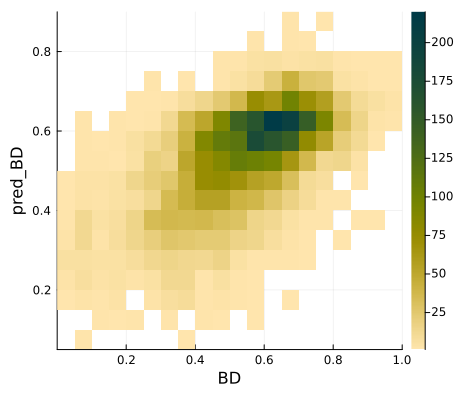

Plotting SOCconc: valid points = 56117


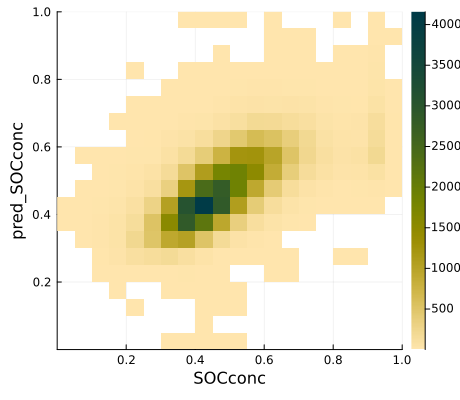

Plotting CF: valid points = 5194


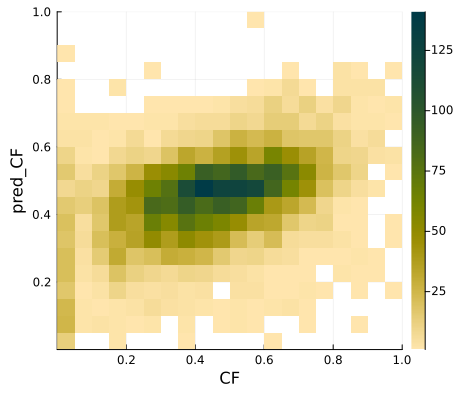

Plotting SOCdensity: valid points = 5194


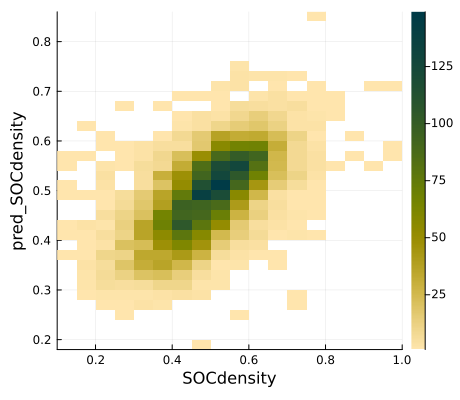

In [9]:
for tgt in ["BD", "SOCconc", "CF", "SOCdensity"]

    true_vals = rlt_pred[:, Symbol(tgt)]
    pred_vals = rlt_pred[:, Symbol("pred_", tgt)]

    # 过滤掉 invalid 值（避免 NaN 出图报错）
    mask = map(!isnan, true_vals) .& map(!isnan, pred_vals)
    x = true_vals[mask]
    y = pred_vals[mask]

    println("Plotting $tgt: valid points = ", length(x))

    plt = histogram2d(
        x, y;
        nbins = (30, 30),
        cbar = true,
        xlab = tgt,
        ylab = "pred_$tgt",
        color = cgrad(:bamako, rev=true),
        normalize = false,
        size = (460, 400),
    )

    display(plt)
end

Variable: pred_BD
  Valid count = 56117
  Min = 0.020759397124622155
  Max = 1.0490467779695078



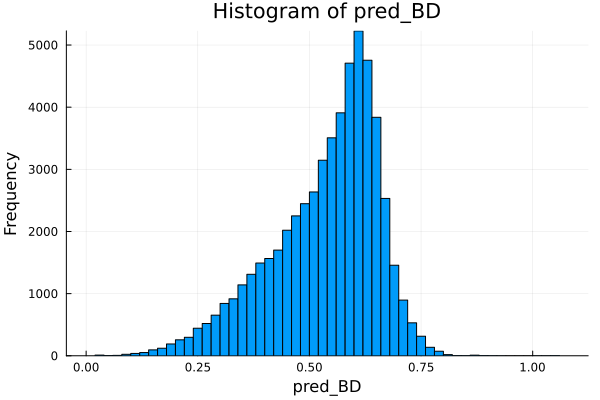

Variable: pred_SOCconc
  Valid count = 56117
  Min = 0.00012614073
  Max = 0.99991417



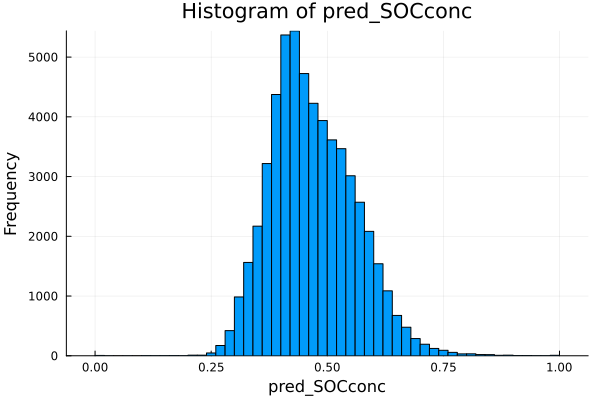

Variable: pred_CF
  Valid count = 56117
  Min = 2.5406125e-8
  Max = 1.0



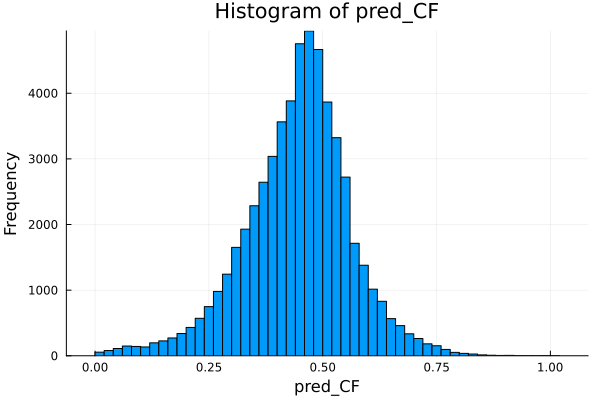

Variable: pred_SOCdensity
  Valid count = 56117
  Min = 0.0
  Max = 0.9144057637153742



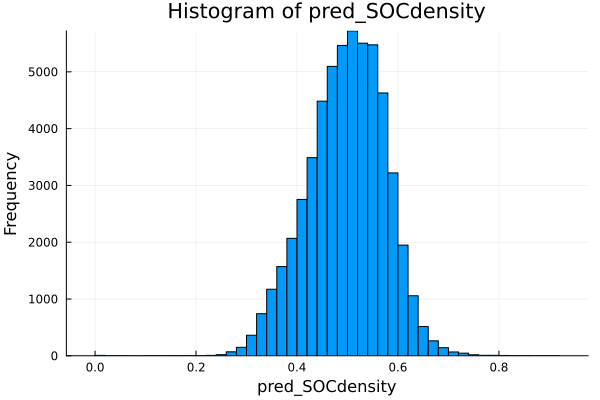

In [10]:
for col in ["pred_BD", "pred_SOCconc", "pred_CF", "pred_SOCdensity"]

    vals = rlt_pred[:, col]

    # 有效值（非 missing 且非 NaN）
    valid_vals = filter(x -> !ismissing(x) && !isnan(x), vals)

    n_valid = length(valid_vals)
    vmin = minimum(valid_vals)
    vmax = maximum(valid_vals)

    println("Variable: $col")
    println("  Valid count = $n_valid")
    println("  Min = $vmin")
    println("  Max = $vmax\n")

    histogram(
        vals;
        bins = 50,
        xlabel = col,
        ylabel = "Frequency",
        title = "Histogram of $col",
        lw = 1,
        legend = false
    )
    display(current())
end
